In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier as XGBC
from sklearn.metrics import confusion_matrix as cm, recall_score as recall, roc_auc_score as auc
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
# warning: 版本兼容性问题

In [2]:
data_train = pd.read_csv('/home/yfy/Desktop/projects/NII_image_classify/binary_classification/dogs_cats_train.csv', index_col=0)
data_val = pd.read_csv('/home/yfy/Desktop/projects/NII_image_classify/binary_classification/dogs_cats_validation.csv', index_col=0)

In [3]:
Xtrain = data_train.iloc[:,:100]
Ytrain = data_train.iloc[:,-1]
Xval = data_val.iloc[:,:100]
Yval = data_val.iloc[:,-1]
X = pd.concat([Xtrain,Xval],axis=0)
Y = pd.concat([Ytrain,Yval],axis=0)

In [42]:
X.index = range(len(X))
Y.index = range(len(Y))

In [51]:
X.iloc[1560,:]

0      6.0
1      8.0
2      7.0
3      9.0
4      6.0
      ... 
95     8.0
96     6.0
97     9.0
98    11.0
99     5.0
Name: 1560, Length: 100, dtype: float64

In [72]:
clf = XGBC(n_estimators=10).fit(Xtrain,Ytrain)

[22:47:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [73]:
clf.score(Xval,Yval)  # 没有调参的结果

0.5192307692307693

In [78]:
clf = XGBC(n_estimators=100,random_state=420)

In [81]:
CVS(clf,X,Y,cv=5,scoring='accuracy').mean()

/home/yfy/anaconda3/envs/opencv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:52:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:52:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:52:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:52:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

0.7384615384615384

In [64]:
# 定义：绘制以样本数量为横坐标的学习曲线函数

def plot_learning_curve(estimator,title, X, y, 
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            ,random_state=420
                                                            ,n_jobs=n_jobs)      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

In [65]:
cv = KFold(n_splits=5, shuffle = True, random_state=42) #交叉验证模式

/home/yfy/anaconda3/envs/opencv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:44:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:44:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:44:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

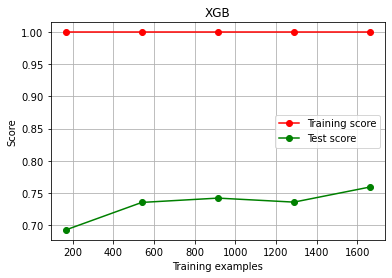

In [68]:
plot_learning_curve(XGBC(n_estimators=100,random_state=420)
                    ,"XGB",X,Y,ax=None,cv=cv)
plt.show()

[22:52:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:52:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:52:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:52:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[22:53:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[22:53:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:53:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[22:54:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
110 0.7692307692307692


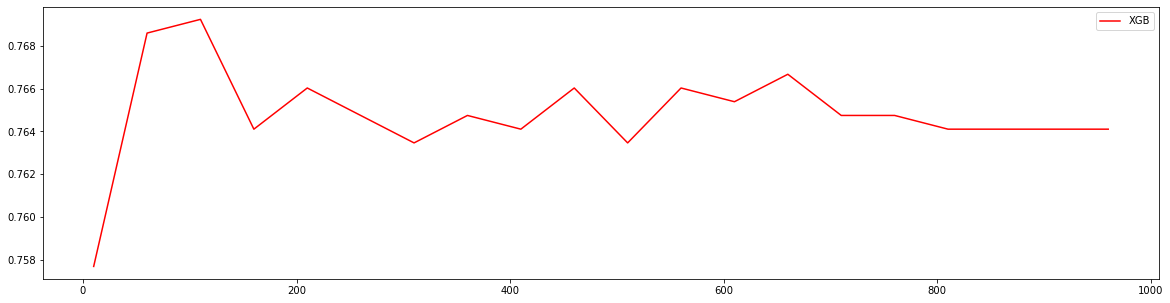

In [83]:
axisx = range(10,1010,50)
rs = []
for i in axisx:
    clf = XGBC(n_estimators=i,random_state=420)
    rs.append(CVS(clf,Xtrain,Ytrain,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()


In [ ]:
import time

In [ ]:
print(time.time())